# imports

In [3]:
import pandas as pd # Таблицы
from tabulate import tabulate # Оформление таблицы
import numpy as np # Для массивов, sqrt, sing, ln
import matplotlib.pyplot as plt # Для построения графиков
from matplotlib.pyplot import figure # Для коррекции размера выводимого изображения
import sympy as sy # Для дифференциирования - функции diff()
from mpl_toolkits.axes_grid.axislines import SubplotZero
from matplotlib.transforms import BlendedGenericTransform

<ipython-input-3-b971cd2eec72>:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.axislines import SubplotZero


# График целевой функции

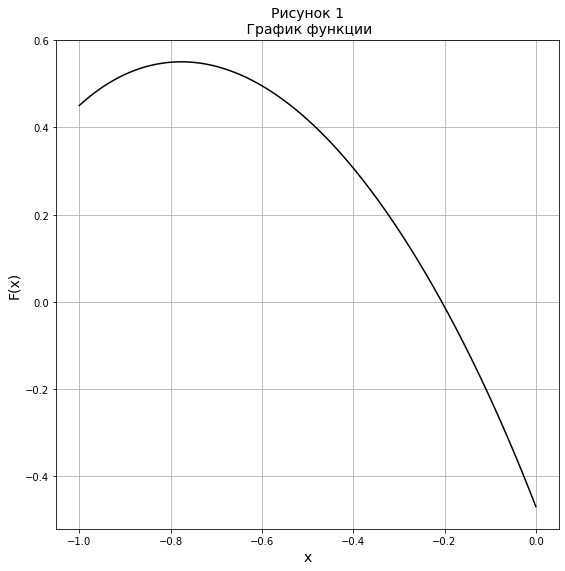

In [111]:
Eps, interval, max_iters, num_of_picture = [1e-2, 1e-5, 1e-17], np.linspace(-1, 0, 1000), 1000000, 0
#Три значения Eps, интервал, максимальное кол-во итераций, номер рисунка

def F(x): # Задаем саму функци
    return np.log(2 * x ** 5 - 7 * x + np.sqrt(11)) + np.sinh((-4 * x ** 2 - 4 * x + 3 - 4 * np.sqrt(2)) / (3 * x ** 2 + 3 * x + 3 * np.sqrt(2))) - 1.0
def F1(x): # 'Первернутая' функция для метода Пауэлла
    return F(x) * (-1)

num_of_picture += 1 # Нумерация рисунков    
plt.figure(figsize=(9, 9)) # Размер выводимого изображения
plt.title('Рисунок {}'.format(num_of_picture) + '\n {}'.format('График функции'),size=14) # Определим заголовок
plt.plot(interval, F(interval), color='black')
plt.xlabel('x', size=14)
plt.ylabel('F(x)', size=14)

# color - цвет, мы выбираем красный
# linestyle - стиль линии
# marker - символ которым мы обозначаем точку
# label - легенда
plt.grid(True) # Включаем сетку на Oxy
plt.show() # Вывести график на экран

# Функция вывода

In [91]:

def output(method): # Создадим функцию вывода таблицы и графика в общем виде
    name = 'Метод дихотомии' if method == dichotomy else 'Метод золотого сечения'
    if method == dichotomy:
        func = F
        name = 'Метод дихотомии'
    elif method == GSC:
        func = F
        name = 'Метод золотого сечения'
    else:
        func = F1 # Исопльзуем 'перевернутую' функцию
        name = 'Метод квадратичной аппроксимации'
    x_res, f_res, iters, funcalls = [], [], [], []
    for each_eps in Eps: # Запустим цикл для каждой точности Eps
        result = method(func, -1, 0, each_eps, max_iters) # Помещаем результат в массив
        x_res.append(result[0]) # x_min для каждого Eps
        f_res.append(func(result[0])) # f(x_min) для каждого Eps
        iters.append(result[1]) # Количество итераций для каждого Eps
        funcalls.append(result[2]) # Количество вызовов функций для каждого Eps
        

        
        global num_of_picture
        num_of_picture += 1
        plt.figure(figsize=(9,9)) # Размер выводимого изображения
        # result[3] - множество длин отрезков, которые сужают интервал по оси X
        x1 = [result[3][i][-1] for i in range(len(result[3]))] # Возьмем наши длины отрезков с некоторым шагом
        x2 = [result[3][i][0] for i in range(len(result[3]))]
        y = result[4]
        plt.title('Рисунок {}.  Интервал неопределенности.'.format(num_of_picture) + '\n {}'.format(name)+ '\n Eps = {}'.format(each_eps) ,size=14)
        plt.hlines(y, x2, x1)
        plt.xlabel('Длина промежутка', size=14)
        plt.ylabel('Итерации', size=14)
        # color - цвет, мы выбираем красный
        # linestyle - стиль линии
        # marker - символ которым мы обозначаем точку
        # label - легенда
        plt.grid(True) # Включаем сетку на Oxy
        plt.show() # Вывести график на экран

    # Создадим таблицу с нашими данным
    table = pd.DataFrame({'X_min ' : x_res,
                          'F(X_min) ' : f_res,
                          'Num of iters ': iters,
                          'Num of func calls ' : funcalls,
                         'Eps ' : Eps})
     #Выведем таблицу
    print(name, tabulate(table, headers='keys', tablefmt='psql'), sep = '\n')

# Метод дихотомии

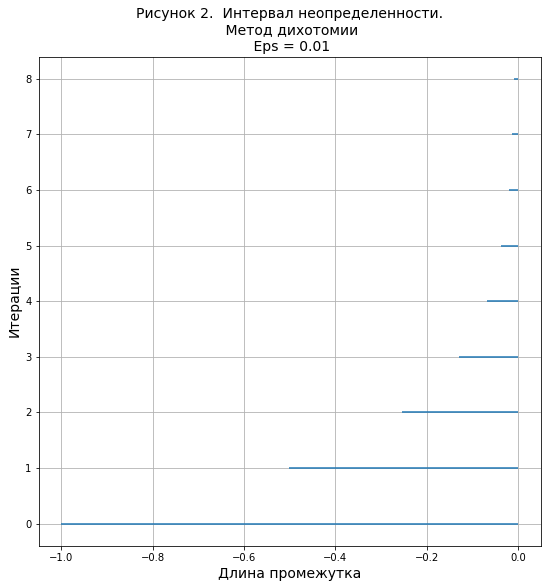

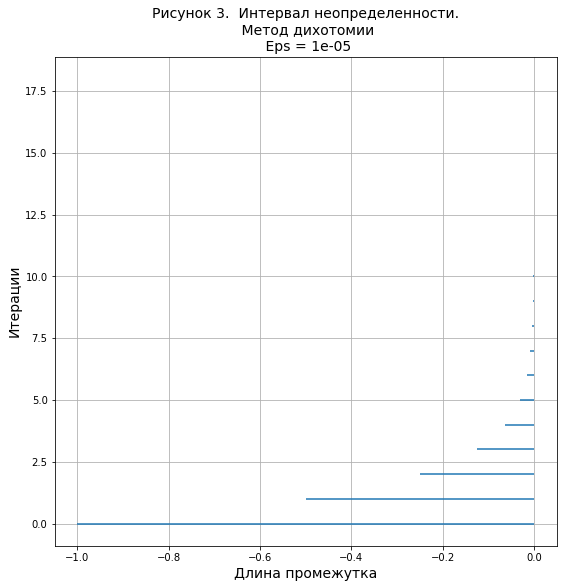

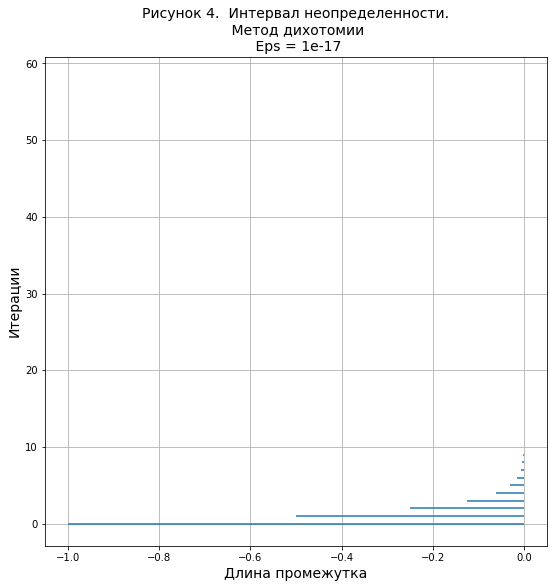

Метод дихотомии
+----+--------------+-------------+-----------------+----------------------+--------+
|    |       X_min  |   F(X_min)  |   Num of iters  |   Num of func calls  |   Eps  |
|----+--------------+-------------+-----------------+----------------------+--------|
|  0 | -0.00444336  |   -0.457018 |               8 |                   16 |  0.01  |
|  1 | -4.40734e-06 |   -0.469007 |              18 |                   36 |  1e-05 |
|  2 | -4.23472e-18 |   -0.469019 |              58 |                  116 |  1e-17 |
+----+--------------+-------------+-----------------+----------------------+--------+


In [112]:
def dichotomy(F, left, right, Eps, max_iters):
    counter = funcalls = 0 # Заведем перемнные для подсчета кол-ва итераций и кол-ва вызовов ф-ции
    dotes, iters = [], [] # Инициализируем массив границ промежутка и итераций
    dotes.append([left, right])# Занесем в массив начальные конца отрезка
    iters.append(counter) # Занесем в массив начальную итерацию
    sigma = Eps / 2 # sigma - константая различимость
    while abs(right - left) > Eps and counter <= max_iters: #|right - left| < Eps - условие выхода
        x1 = (left + right - sigma)/2 # Возьмем левый конец чуть левее середины отрезка
        x2 = (left + right + sigma)/2 # Возьмем правый конец чуть правее середины отрезка
        if F(x1) * F(x2) > 0:
            left = x1
        else:
            right = x2
        dotes.append([left, right]) # Добавим новые концы отрезка
        counter += 1
        iters.append(counter) # Добавим следующую итерацию
        funcalls += 2 # Т.к. в конструкци if-else мы вызываем ф-цию дважды, прибавляем 2
    return [(left + right) / 2, counter, funcalls, dotes, iters]


output(dichotomy)

Из полученных результатов сделаем выводы:  
1) Сам метод прост, как в реализации, так и в действии;  
2) Так как функция будет рассматривать точки $x_1$ и $x_2$, вне зависимости от данных, алгоритм будет работать с любыми данными также, как и в в худшем. Т.е. мы будем рассматривать множество лишних данных;  
3) При малом кол-ве итераций - корректно, при большом - некорректно. Это связано с тем, что при увелечении количества итераций элементы дихотомического деления, будут более схожи между собой, т.е. $x_1$ и $x_2$ будут очень близки по значению, что затрудняет поиск мнимума;  
4) При уменьшении Eps, наш отрезок [left, right] может становиться большей длины, что повлияет на точность вычисления x_min.  

## Метод золотого сечения

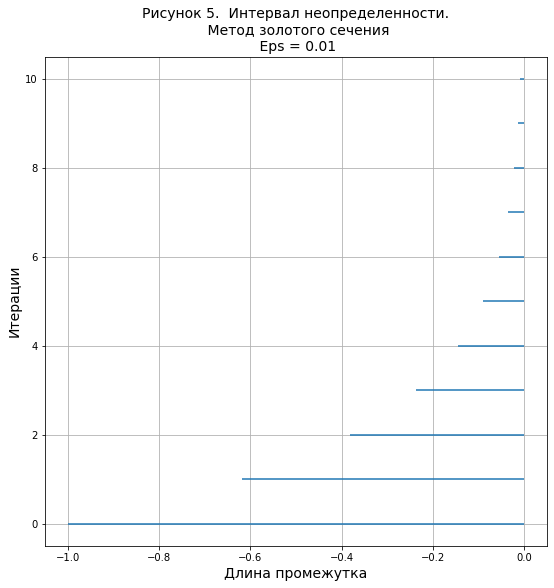

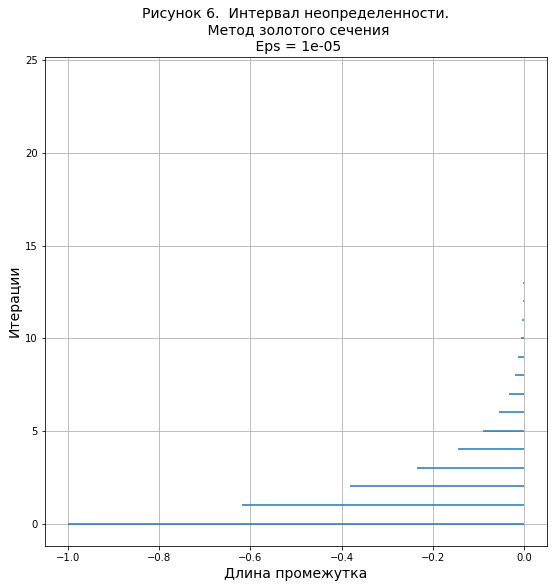

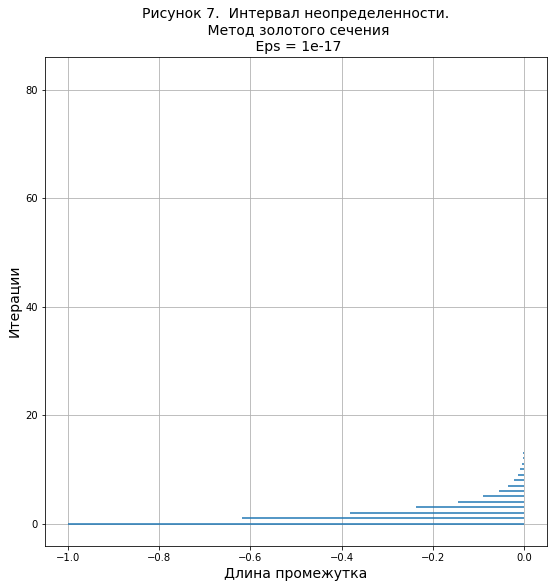

Метод золотого сечения
+----+--------------+-------------+-----------------+----------------------+--------+
|    |       X_min  |   F(X_min)  |   Num of iters  |   Num of func calls  |   Eps  |
|----+--------------+-------------+-----------------+----------------------+--------|
|  0 | -0.00406531  |   -0.458035 |              10 |                   20 |  0.01  |
|  1 | -4.82244e-06 |   -0.469006 |              24 |                   48 |  1e-05 |
|  2 | -1.50859e-16 |   -0.469019 |              82 |                  164 |  1e-17 |
+----+--------------+-------------+-----------------+----------------------+--------+


In [113]:
def GSC(F, left, right, Eps, max_iters):
    counter = funcalls = 0 # Заведем перемнные для подсчета кол-ва итераций и кол-ва вызовов ф-ции
    dotes, iters = [], [] # Инициализируем массив границ промежутка и итераций
    dotes.append([left, right]) # Занесем в массив начальные конца отрезка
    iters.append(counter) # Занесем в массив начальную итерацию
    Fi = (np.sqrt(5) + 1) / 2 # Пропорция золотого сечения
    while abs(right - left) > Eps and counter <= max_iters: # |right - left| < Eps - условие выхода
        x1 = right - (right - left) / Fi #точка x1 делит отрезок [a, x2] в отношении золотого сечения
        x2 = left + (right - left) / Fi #точка x2 делит отрезок [x1, b] в отношении золотого сечения
        if F(x1) >= F(x2):    
            left = x1
        else:
            right = x2
        dotes.append([left, right]) # Добавим новые концы отрезка
        counter += 1
        iters.append(counter) # Добавим следующую итерацию
        funcalls += 2 # Т.к. в конструкци if-else мы вызываем ф-цию дважды, прибавляем 2
    return [(right + left) / 2, counter, funcalls, dotes, iters]


output(GSC)

Из полученных результатов сделаем выводы:  
1) Аналогично, метод довольно таки прост;  
2) Кол-во итераций не влияет на результат, лишь увеличивает время работы алгоритма;  
3) Eps не влияет на результат, однако заметно увеличивает время работы алгоритма;  
4) Алгоритм универсален, в плане поступающих данных. Т.е. поступят плохие данные - отработает плохо, иначе  - хорошо. Под словами 'хорошо' и 'плохо', я имею в виду, что может достигаться как нижняя, так и верхняя ассимптотическая граница алгоритма.


# Метод квадратичной аппроксимации

[0, 1]


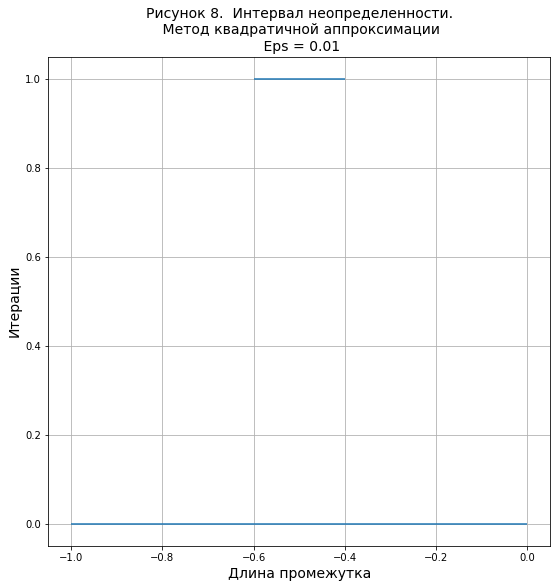

[0, 1, 2, 3, 4, 5]


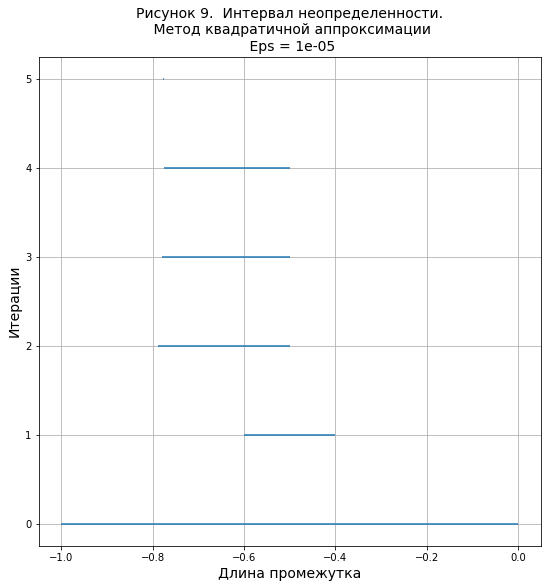

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


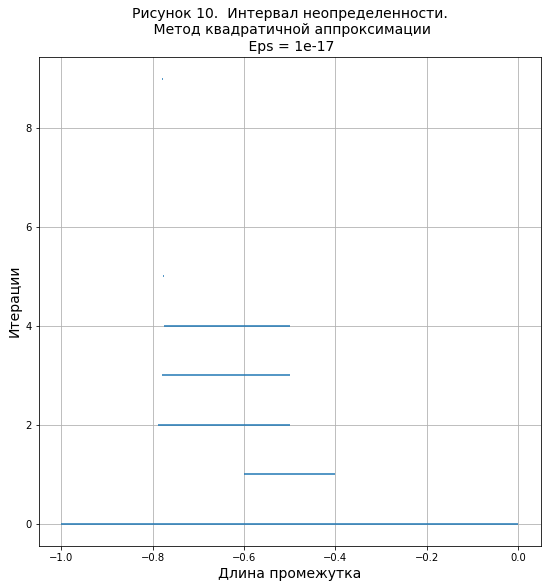

Метод квадратичной аппроксимации
+----+-----------+-------------+-----------------+----------------------+--------+
|    |    X_min  |   F(X_min)  |   Num of iters  |   Num of func calls  |   Eps  |
|----+-----------+-------------+-----------------+----------------------+--------|
|  0 | -0.5      |   -0.417775 |               1 |                    2 |  0.01  |
|  1 | -0.776581 |   -0.550518 |               5 |                    6 |  1e-05 |
|  2 | -0.77665  |   -0.550518 |               9 |                   10 |  1e-17 |
+----+-----------+-------------+-----------------+----------------------+--------+


In [114]:
# Для начала определим производную функции, которая нужна, чтобы считать локальный экстремум
x = sy.Symbol('x')
y = -(sy.sin((-x ** 4 - 4 * x ** 3 - 8 * x ** 2 - 7 * x + 1) / sy.sqrt(11)) + sy.log((4 * x ** 5 - 4 * sy.sqrt(11) * x ** 4 + 8 * x ** 3 + 5 * x ** 2 - 5 * sy.sqrt(10) * x + 9) / (x ** 2 - sy.sqrt(10) * x + 2)) / sy.log(10) - 1.0)
dx = sy.diff(y, x)
ddx = sy.lambdify(x, dx)


def powell(f, left, right, Eps, max_iters):
    count = 0
    dotes, iters = [], [] # Инициализируем массив границ промежутка и итераций
    dotes.append([left, right]) # Занесем в массив начальные конца отрезка    
    iters.append(count) # Занесем в массив начальную итерацию
    flag, funcalls = True, 0
    x2 = (left + right) / 2 # Определим середину
    f2 = f(x2)
    x1 = x2 # Определим стартвоую позицию левого конца будущего интервала 
    dx = 0.1 * (right - left) # Определим шаг
    while flag and (x1 - dx) >= left: # Если точка не найдена и мы не вышли за границы
        x1 -= dx # Идем к границе с шагом dx
        f1 = f(x1) 
        funcalls += 1
        """
        Чтобы определить 3 точки, нам достаточно найти точку, которая лежит по другую сторону перегиба от средней и точку, которая лежит правее/левее средней.
        Такое утверждение справедливо, так как в рамках задачи, экстремум будет только 1.
        P.S. можно было взять и вторую производную, но я сделаю это с помощью свойства унимодальности производной)
        """
        
        if f1 > f2 or ddx(x1) * ddx(x2) < 0: # Т.е. если мы перешагнули через экстремум, знак производной поменяется
            flag = False # Точка найдена
    if flag: # Если такой точки не нашли
        print('x1 not founded')
        return 0
    flag = True
    x3 = x2 # Определим стартвоую позицию правого конца будущего интервала 
    while flag and (x3 + dx) <=right: # Если точка не найдена и мы не вышли за границы
        x3 += dx # Идем к границе с шагом dx
        f3 = f(x3)
        funcalls += 1
        if f3 > f2 or ddx(x3) * ddx(x2) < 0:
            flag = False # Точка найдена

    if flag: # Если такой точки не нашли
        print('x3 not founded')
        return 0
    dotes.append([x3, x1]) # Добавим новый интервал
    count += 1 # Добавим счетчик итераций
    iters.append(count) # Занесем в массив первую итерацию
    while True: 
        x5 = ((x3) ** 2 - (x2) ** 2) * f1 + ((x1) ** 2 - (x3) ** 2) * f2 + ((x2) ** 2 - (x1) ** 2) *f3
        x6 = 2 * ((x3 - x2) * f1 + (x1 - x3) * f2 + (x2 - x1) * f3)
        if abs(x6) < Eps: # x4 = x5/x6, x6 - знаменатель, если он не равнен нулю, то:
            differ = 0
        else:
            x4 = x5 / x6
            f4 = f(x4)
            funcalls += 1
            differ = ddx(x4)
            # Продолжаем сужать наш интервал, если это необходимо
            if abs(differ) < Eps:
                x2 = x4
            else:
                if f4 < f2:            
                    if x4 < x2:
                        x3 = x2
                        f3 = f2
                    else:
                        x1 = x2
                        f1 = f2
                    x2 = x4
                    f2 = f4
                    dotes.append([x4, x3])
                else:
                    if x4 > x2:
                        x3 = x2
                        f3 = f2
                        dotes.append([x4, x1])
                    else:
                        x1 = x4
                        f1 = f4
                        dotes.append([x2, x1])
        if abs(differ) < Eps and count <= max_iters:
            print(iters)
            return [x2, count, funcalls, dotes, iters]
        count += 1
        iters.append(count)
output(powell)

Наша функция не годиться для поиска минимума с помощью метода квадратичной аппроксимации. 
Программа не сможет найти $x_3$, так как все значения функции правее середины, меньше значения функции в серединной точке (f3 < f1).  
Возьмум функцию F1(x) = F(x) * (-1), чтобы 'перевернуть' нашу функцию и сделать локальный максимум - минимумом.  

Из полученных результатов сделаем выводы:  

1) Алгоритм средней сложности в реализцаии;  

2) Кол-во итераций не влияет на результат, лишь увеличивает время работы алгоритма;  

3) Eps не влияет на результат, лишь увеличивает время работы алгоритма;  

4) Алгоритм быстродейственный.  

5) Алгоритм не справиться с линейными функциями. Также он некорректно отработает, когда f'' $\leq$ 0, так как функция будет выпукла вверх и вершиной параболы окажется локальный максимум, хотя ищем мы минимум.

# Выводы

В данной работе я использовал 3 метода оптимизации, чтобы найти локальный минимум функции и значение целевой функции в данной точке.  

Попробуем проанализировать результаты методов, чтобы сделать выводы о них:

По быстродействию:

1) Метод Пауэлла;  

2) Метод дихотомии;  

3) Метод золотого сечения; 

Хоть метод дихотомии и быстрее метода золотого сечения, но при малых точностях работает некорректно. А метод золотого сечения при малых точностях работает корректно, хоть и в результате огромного количества итераций.  

По простоте метод дихотомии и метод золотого сечения аналогичны, а вот метод Пауэлла сложнее в реализации.  

Хоть метод Пауэлла выглядит самым оптимальным и наилучшим вариантом для поиска локального экстремума, у него есть явные недостатки. Так как мы аппроксимируем функцию параболой, наша функция должна быть многочленом как минимум второй степени. Если функция выпукла вверх/вниз мы сможем найти лишь локальный максимум/минимум.  
  
  
Ошибки RuntimeWarning в программе неизбежны, так как функция считает большой массив данных и некоторые значения оказываются некорректными и им присваивается значение NaN.

In [14]:
x = sy.Symbol('x')
y = -(sy.sin((-x ** 4 - 4 * x ** 3 - 8 * x ** 2 - 7 * x + 1) / sy.sqrt(11)) + sy.log((4 * x ** 5 - 4 * sy.sqrt(11) * x ** 4 + 8 * x ** 3 + 5 * x ** 2 - 5 * sy.sqrt(10) * x + 9) / (x ** 2 - sy.sqrt(10) * x + 2)) / sy.log(10) - 1.0)
print(sy.diff(y, x))

-((-2*x + sqrt(10))*(4*x**5 - 4*sqrt(11)*x**4 + 8*x**3 + 5*x**2 - 5*sqrt(10)*x + 9)/(x**2 - sqrt(10)*x + 2)**2 + (20*x**4 - 16*sqrt(11)*x**3 + 24*x**2 + 10*x - 5*sqrt(10))/(x**2 - sqrt(10)*x + 2))*(x**2 - sqrt(10)*x + 2)/((4*x**5 - 4*sqrt(11)*x**4 + 8*x**3 + 5*x**2 - 5*sqrt(10)*x + 9)*log(10)) - sqrt(11)*(-4*x**3 - 12*x**2 - 16*x - 7)*cos(sqrt(11)*(-x**4 - 4*x**3 - 8*x**2 - 7*x + 1)/11)/11
